###Install Library

In [ ]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q "transformers[torch]" accelerate -U
!pip install -q -U accelerate
!pip install -q datasets
!pip install -q gensim
!pip install -q tensorflow
!pip install -q evaluate

### Import Library

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load as load_metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

###Read Dataset and load Word2Vec

In [ ]:
df = pd.read_csv("/content/news_train_balanced_clean.csv")

In [ ]:
df_test1 = pd.read_csv("/content/news_test_clean.csv")

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [ ]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")


Model Available


In [ ]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [ ]:
x_train = df['Text']
y_train = df['Label']

In [ ]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [ ]:
# # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [ ]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
# lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000
max_sequence_length = 100 # Moving the definition of max_sequence_length here

In [ ]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [ ]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [ ]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [ ]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [ ]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [ ]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##LSTM Model

In [ ]:
# Define the architecture of the static model with he_normal initialization
lstm_input = Input(shape=(max_sequence_length,))
lstm_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(lstm_input)  # Removed weights parameter

# LSTM Layers
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(lstm_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer = BatchNormalization()(static_lstm_output)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(batch_norm_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the static model
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###LSTM BorderlineSMOTE Train and Test

In [ ]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_borderline = lstm_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=128,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 208ms/step - accuracy: 0.5090 - loss: 0.8145 - val_accuracy: 0.0019 - val_loss: 0.7629
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5325 - loss: 0.6960 - val_accuracy: 0.0019 - val_loss: 0.7460
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5507 - loss: 0.6886 - val_accuracy: 0.0019 - val_loss: 0.7884
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5531 - loss: 0.6878 - val_accuracy: 0.0019 - val_loss: 0.7733
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5548 - loss: 0.6877 - val_accuracy: 0.0019 - val_loss: 0.7722
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5588 - loss: 0.6865 - val_accuracy: 0.0019 - val_loss: 0.7872
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5538 - loss: 0.6871 - val_accuracy: 0.0019 - val_loss: 0.7936
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.5568 - loss: 0

####Cross-Validation Train

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.4983 - loss: 0.6949 - val_accuracy: 0.5009 - val_loss: 0.6927
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4984 - loss: 0.6931 - val_accuracy: 0.4999 - val_loss: 0.6929
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4977 - loss: 0.6930 - val_accuracy: 0.5009 - val_loss: 0.6927
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4972 - loss: 0.6929 - val_accuracy: 0.4999 - val_loss: 0.6930
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.1782 - loss: 0.7026
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1859 - loss: 0.7021
Fold 1 - Training Loss: 0.6927933096885681, Training Accuracy: 0.49989697337150574
Fold 1 - Validation Loss: 0.6926882863044739, Validation Accuracy: 0.5009271502494812
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
              precision    recall  f1-score   support

           0       0.00      0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4989 - loss: 0.6927 - val_accuracy: 0.5028 - val_loss: 0.6927
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4961 - loss: 0.6931 - val_accuracy: 0.5028 - val_loss: 0.6927
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4976 - loss: 0.6930 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4988 - loss: 0.6932 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4979 - loss: 0.6929 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4957 - loss: 0.6928 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4990 - loss: 0.6928 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4991 - loss: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.5033 - loss: 0.6927 - val_accuracy: 0.5121 - val_loss: 0.6931
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.5042 - loss: 0.6928 - val_accuracy: 0.4879 - val_loss: 0.6932
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4982 - loss: 0.6927 - val_accuracy: 0.5121 - val_loss: 0.6930
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4992 - loss: 0.6928 - val_accuracy: 0.4879 - val_loss: 0.6933
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4998 - loss: 0.6927 - val_accuracy: 0.4879 - val_loss: 0.6932
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4989 - loss: 0.6927 - val_accuracy: 0.4879 - val_loss: 0.6933
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8202 - loss: 0.6888
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8305 - loss: 0.6888
Fold 4 - Training Loss: 0.6926495432853699, Training Accura

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.5033 - loss: 0.6927 - val_accuracy: 0.5062 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4988 - loss: 0.6927 - val_accuracy: 0.4946 - val_loss: 0.6927
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4977 - loss: 0.6929 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4998 - loss: 0.6925 - val_accuracy: 0.4946 - val_loss: 0.6927
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.1778 - loss: 0.6937
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1894 - loss: 0.6937
Fold 5 - Training Loss: 0.6926835775375366, Training Accuracy: 0.499308317899704
Fold 5 - Validation Loss: 0.6925838589668274, Validation Accuracy: 0.5062251687049866
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1864
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 214ms/step - accuracy: 0.4993 - loss: 0.6927 - val_accuracy: 0.4906 - val_loss: 0.6931
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4966 - loss: 0.6926 - val_accuracy: 0.5097 - val_loss: 0.6929
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4999 - loss: 0.6927 - val_accuracy: 0.4906 - val_loss: 0.6930
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4995 - loss: 0.6927 - val_accuracy: 0.4906 - val_loss: 0.6931
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4950 - loss: 0.6925 - val_accuracy: 0.4906 - val_loss: 0.6931
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1776 - loss: 0.6940
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1912 - loss: 0.6940
Fold 6 - Training Loss: 0.6926509737968445, Training Accuracy: 0.49892568588256836
Fold 6 - Validation Loss: 0.6929339170455933, Validation Accuracy: 0.5096688866615295
118/118 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 214ms/step - accuracy: 0.5033 - loss: 0.6926 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4957 - loss: 0.6928 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5038 - loss: 0.6925 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4972 - loss: 0.6927 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5001 - loss: 0.6927 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5021 - loss: 0.6926 - val_accuracy: 0.4977 - val_loss: 0.6926
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8216 - loss: 0.6928
118/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 213ms/step - accuracy: 0.4971 - loss: 0.6926 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5004 - loss: 0.6925 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5013 - loss: 0.6927 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5028 - loss: 0.6927 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5024 - loss: 0.6928 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5010 - loss: 0.6927 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4994 - loss: 0.6927 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5051 - loss: 0

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.500064754486084, Std Training Accuracy: 0.0008155813449387287
Mean Training Loss: 0.6926909625530243, Std Training Loss: 5.4892340599460564e-05
Mean Validation Accuracy: 0.5028609275817871, Std Validation Accuracy: 0.0066900379473963986
Mean Validation Loss: 0.6926528155803681, Std Validation Loss: 0.00037612036567758584


In [ ]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.25143166628243396), 'recall': np.float64(0.5), 'f1-score': np.float64(0.3345935171349095), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.6512317880794701), 'recall': np.float64(0.5007983941113483), 'f1-score': np.float64(0.33600222756686254), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_borderline.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_borderline.history['loss'][epoch]
    train_accuracy = history_lstm_borderline.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_borderline.history['val_loss'][epoch]
    val_accuracy = history_lstm_borderline.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [ ]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=128)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9486 - loss: 0.6931
Static Model Evaluation Results:
Accuracy: 0.9527487754821777


In [ ]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2097
           1       0.00      0.00      0.00       104

    accuracy                           0.95      2201
   macro avg       0.48      0.50      0.49      2201
weighted avg       0.91      0.95      0.93      2201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.cuda.empty_cache()

###LSTM KMeansSMOTE Train and Test

In [ ]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_kmeans = lstm_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=128,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 209ms/step - accuracy: 0.5557 - loss: 0.6908 - val_accuracy: 0.0019 - val_loss: 0.7702
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5556 - loss: 0.6870 - val_accuracy: 0.0019 - val_loss: 0.8009
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5574 - loss: 0.6863 - val_accuracy: 0.0019 - val_loss: 0.8066
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5525 - loss: 0.6874 - val_accuracy: 0.0019 - val_loss: 0.8132
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5548 - loss: 0.6868 - val_accuracy: 0.0019 - val_loss: 0.8117
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5605 - loss: 0.6855 - val_accuracy: 0.0019 - val_loss: 0.8065
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5533 - loss: 0.6870 - val_accuracy: 0.0019 - val_loss: 0.8088
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5595 - loss: 0

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 58s 212ms/step - accuracy: 0.5003 - loss: 0.6927 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 206ms/step - accuracy: 0.5013 - loss: 0.6928 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 206ms/step - accuracy: 0.5009 - loss: 0.6927 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5041 - loss: 0.6927 - val_accuracy: 0.5009 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5017 - loss: 0.6928 - val_accuracy: 0.5009 - val_loss: 0.6926
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5019 - loss: 0.6927 - val_accuracy: 0.5009 - val_loss: 0.6926
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4983 - loss: 0.6928 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 213ms/step - accuracy: 0.4968 - loss: 0.6928 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5037 - loss: 0.6927 - val_accuracy: 0.4980 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4957 - loss: 0.6927 - val_accuracy: 0.4980 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5024 - loss: 0.6926 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5029 - loss: 0.6926 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4953 - loss: 0.6928 - val_accuracy: 0.4980 - val_loss: 0.6926
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.4965 - loss: 0.6929 - val_accuracy: 0.4980 - val_loss: 0.6926
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8215 - loss: 0.6916
118/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4972 - loss: 0.6927 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4990 - loss: 0.6926 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4973 - loss: 0.6927 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5053 - loss: 0.6927 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4936 - loss: 0.6927 - val_accuracy: 0.4946 - val_loss: 0.6926
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.8224 - loss: 0.6928
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8107 - loss: 0.6929
Fold 5 - Training Loss: 0.6926795244216919, Training Accuracy: 0.5013686418533325
Fold 5 - Validation Loss: 0.6925987601280212, Validation Accuracy: 0.4945695400238037
118/118 ━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4993 - loss: 0.6927 - val_accuracy: 0.5030 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4972 - loss: 0.6928 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5016 - loss: 0.6925 - val_accuracy: 0.4977 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5017 - loss: 0.6926 - val_accuracy: 0.4977 - val_loss: 0.6926
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.1786 - loss: 0.6933
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1828 - loss: 0.6933
Fold 7 - Training Loss: 0.6926829814910889, Training Accuracy: 0.49966150522232056
Fold 7 - Validation Loss: 0.6925941109657288, Validation Accuracy: 0.5030463337898254
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1876
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.5037 - loss: 0.6927 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4998 - loss: 0.6929 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4924 - loss: 0.6927 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5020 - loss: 0.6926 - val_accuracy: 0.5073 - val_loss: 0.6916
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5023 - loss: 0.6928 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5051 - loss: 0.6928 - val_accuracy: 0.5073 - val_loss: 0.6917
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4976 - loss: 0.6928 - val_accuracy: 0.5073 - val_loss: 0.6917
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.8216 - loss: 0.6909
118/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.5002089738845825, Std Training Accuracy: 0.0008488024287900498
Mean Training Loss: 0.6926715254783631, Std Training Loss: 4.5181868232253616e-05
Mean Validation Accuracy: 0.501562911272049, Std Validation Accuracy: 0.007055712644153499
Mean Validation Loss: 0.6926670730113983, Std Validation Loss: 0.0003979900642351736


In [ ]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.25078230128410767), 'recall': np.float64(0.5), 'f1-score': np.float64(0.3340140108970438), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.7505430463576159), 'recall': np.float64(0.5009558481519362), 'f1-score': np.float64(0.33570687964485674), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_kmeans.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_kmeans.history['loss'][epoch]
    train_accuracy = history_lstm_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_kmeans.history['val_loss'][epoch]
    val_accuracy = history_lstm_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [ ]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=128)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.0514 - loss: 0.6948
Static Model Evaluation Results:
Accuracy: 0.047251250594854355


In [ ]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2097
           1       0.05      1.00      0.09       104

    accuracy                           0.05      2201
   macro avg       0.02      0.50      0.05      2201
weighted avg       0.00      0.05      0.00      2201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.cuda.empty_cache()

###LSTM SVMSMOTE Train and Test

In [ ]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_svm = lstm_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=128,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5487 - loss: 0.6908 - val_accuracy: 0.0019 - val_loss: 0.7644
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5562 - loss: 0.6870 - val_accuracy: 0.0019 - val_loss: 0.7945
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5572 - loss: 0.6864 - val_accuracy: 0.0019 - val_loss: 0.8074
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5580 - loss: 0.6861 - val_accuracy: 0.0019 - val_loss: 0.8098
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5583 - loss: 0.6860 - val_accuracy: 0.0019 - val_loss: 0.8077
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5523 - loss: 0.6873 - val_accuracy: 0.0019 - val_loss: 0.8112
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.5549 - loss: 0.6869 - val_accuracy: 0.0019 - val_loss: 0.8096
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5542 - loss: 0

####Cross-Validation Train

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4987 - loss: 0.6972 - val_accuracy: 0.4999 - val_loss: 0.6933
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5015 - loss: 0.6930 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4985 - loss: 0.6928 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5022 - loss: 0.6927 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4934 - loss: 0.6925 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5064 - loss: 0.6927 - val_accuracy: 0.5009 - val_loss: 0.6926
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4926 - loss: 0.6926 - val_accuracy: 0.4999 - val_loss: 0.6926
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4932 - loss: 0.6927 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5021 - loss: 0.6928 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.5052 - loss: 0.6928 - val_accuracy: 0.4980 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4897 - loss: 0.6928 - val_accuracy: 0.5028 - val_loss: 0.6926
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4986 - loss: 0.6927 - val_accuracy: 0.4980 - val_loss: 0.6926
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8215 - loss: 0.6915
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8193 - loss: 0.6915
Fold 2 - Training Loss: 0.6926872730255127, Training Accuracy: 0.5004562139511108
Fold 2 - Validation Loss: 0.6925873160362244, Validation Accuracy: 0.5027814507484436
118/118 ━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.5066 - loss: 0.6926 - val_accuracy: 0.5121 - val_loss: 0.6931
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5024 - loss: 0.6926 - val_accuracy: 0.4879 - val_loss: 0.6932
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4968 - loss: 0.6924 - val_accuracy: 0.4879 - val_loss: 0.6932
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5011 - loss: 0.6926 - val_accuracy: 0.4879 - val_loss: 0.6932
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.8202 - loss: 0.6927
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8305 - loss: 0.6928
Fold 4 - Training Loss: 0.6926259398460388, Training Accuracy: 0.4994260370731354
Fold 4 - Validation Loss: 0.6931350231170654, Validation Accuracy: 0.5120529532432556
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      1933
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4983 - loss: 0.6927 - val_accuracy: 0.5062 - val_loss: 0.6926
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4963 - loss: 0.6925 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5044 - loss: 0.6928 - val_accuracy: 0.4946 - val_loss: 0.6926
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4974 - loss: 0.6927 - val_accuracy: 0.4946 - val_loss: 0.6926
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.1778 - loss: 0.6938
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1894 - loss: 0.6938
Fold 5 - Training Loss: 0.6926881074905396, Training Accuracy: 0.499308317899704
Fold 5 - Validation Loss: 0.6925818920135498, Validation Accuracy: 0.5062251687049866
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1864
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4986 - loss: 0.6925 - val_accuracy: 0.4906 - val_loss: 0.6930
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4995 - loss: 0.6925 - val_accuracy: 0.4906 - val_loss: 0.6931
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4997 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.6931
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5026 - loss: 0.6926 - val_accuracy: 0.4906 - val_loss: 0.6930
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.8226 - loss: 0.6927
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8089 - loss: 0.6928
Fold 6 - Training Loss: 0.6926359534263611, Training Accuracy: 0.5018101334571838
Fold 6 - Validation Loss: 0.6929720044136047, Validation Accuracy: 0.4905960261821747
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1851
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.5019 - loss: 0.6927 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5036 - loss: 0.6928 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5041 - loss: 0.6928 - val_accuracy: 0.5073 - val_loss: 0.6917
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5031 - loss: 0.6929 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.4928 - loss: 0.6927 - val_accuracy: 0.4948 - val_loss: 0.6917
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5039 - loss: 0.6927 - val_accuracy: 0.4948 - val_loss: 0.6917
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8216 - loss: 0.6916
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8185 - loss: 0.6913
Fold 8 - Training Loss: 0.6927837133407593, Training Accura

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.4999 - loss: 0.6927 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5036 - loss: 0.6926 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5058 - loss: 0.6926 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5035 - loss: 0.6925 - val_accuracy: 0.4964 - val_loss: 0.6930
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - accuracy: 0.5009 - loss: 0.6927 - val_accuracy: 0.4964 - val_loss: 0.6930
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.8215 - loss: 0.6929
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8187 - loss: 0.6931
Fold 10 - Training Loss: 0.6926316022872925, Training Accuracy: 0.5011626482009888
Fold 10 - Validation Loss: 0.6929637789726257, Validation Accuracy: 0.4964238405227661
118/118 ━━━━━━━━━━━━

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.5002178072929382, Std Training Accuracy: 0.0008616950860725837
Mean Training Loss: 0.6926742732524872, Std Training Loss: 4.4022333435844825e-05
Mean Validation Accuracy: 0.5014834403991699, Std Validation Accuracy: 0.007117350235218421
Mean Validation Loss: 0.6926669180393219, Std Validation Loss: 0.00039840996945751515


In [ ]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.2507428825576575), 'recall': np.float64(0.5), 'f1-score': np.float64(0.33397625556739297), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.6505695364238411), 'recall': np.float64(0.500692391280227), 'f1-score': np.float64(0.3352069537868196), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_svm.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_svm.history['loss'][epoch]
    train_accuracy = history_lstm_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_svm.history['val_loss'][epoch]
    val_accuracy = history_lstm_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [ ]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=128)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9486 - loss: 0.6931
Static Model Evaluation Results:
Accuracy: 0.9527487754821777


In [ ]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2097
           1       0.00      0.00      0.00       104

    accuracy                           0.95      2201
   macro avg       0.48      0.50      0.49      2201
weighted avg       0.91      0.95      0.93      2201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.cuda.empty_cache()

##Evaluation

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###LSTM

####BorderlineSMOTE

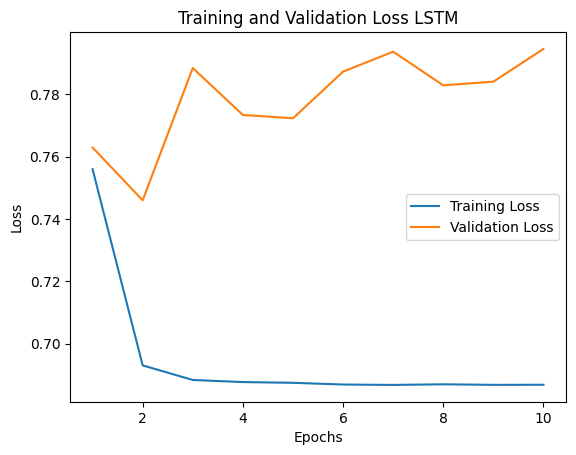

In [ ]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_borderline.history['loss']
val_loss_lstm = history_lstm_borderline.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

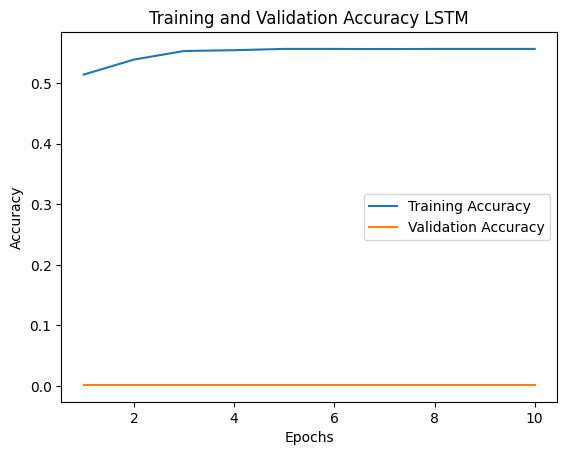

In [ ]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_borderline.history['accuracy']
val_accuracy_lstm = history_lstm_borderline.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


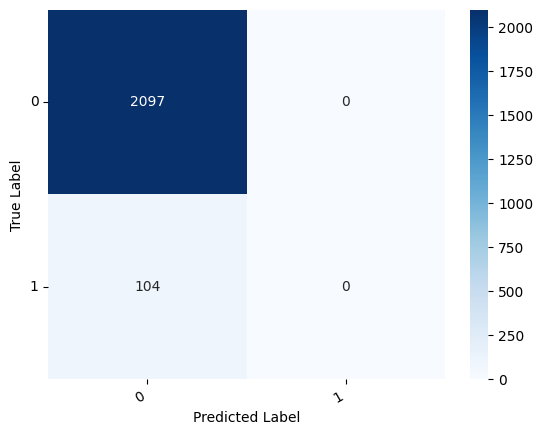

In [ ]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####KMeansSMOTE

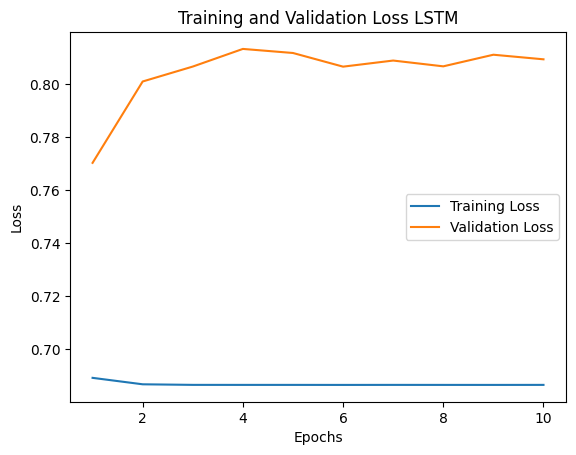

In [ ]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_kmeans.history['loss']
val_loss_lstm = history_lstm_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

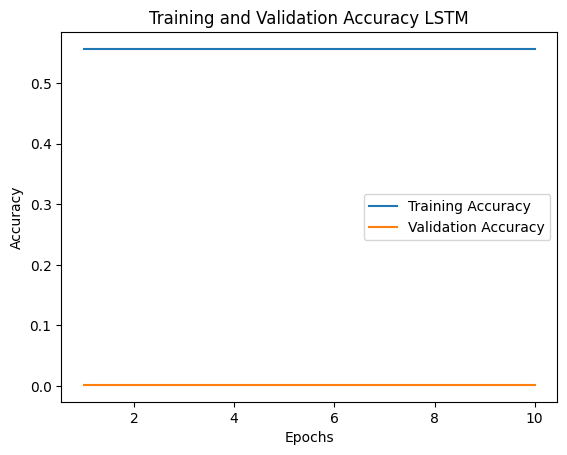

In [ ]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_kmeans.history['accuracy']
val_accuracy_lstm = history_lstm_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


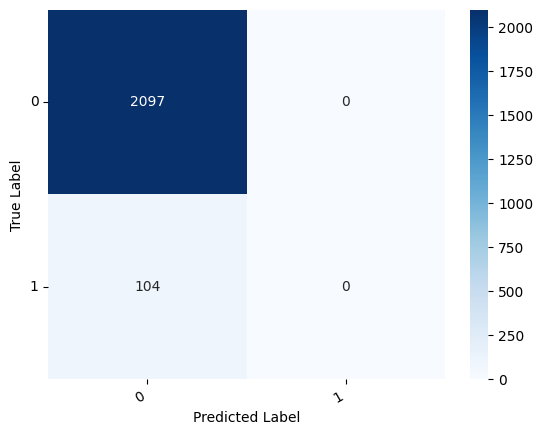

In [ ]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####SVMSMOTE

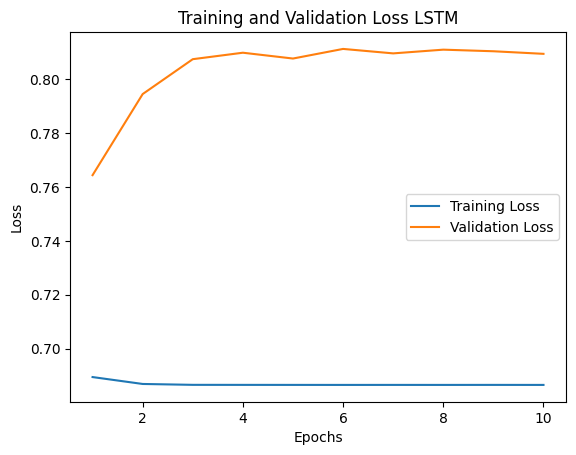

In [ ]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_svm.history['loss']
val_loss_lstm = history_lstm_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

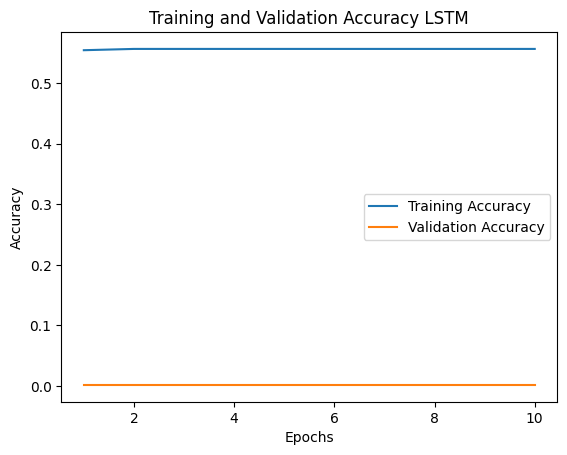

In [ ]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_svm.history['accuracy']
val_accuracy_lstm = history_lstm_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


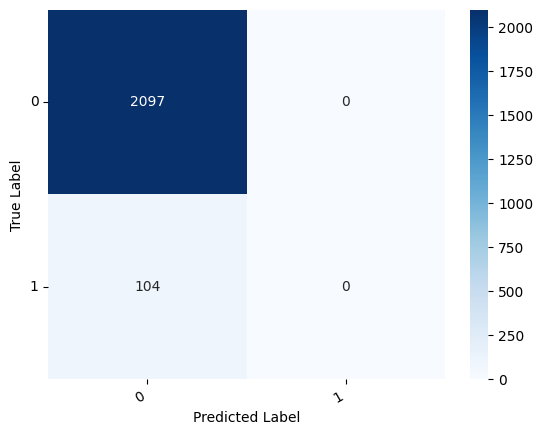

In [ ]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)